In [1]:
%matplotlib inline
# %matplotlib qt

In [2]:
import os

import numpy as np

import matplotlib.colors
import matplotlib.pyplot as plt
from matplotlib.colorbar import cm

from astropy.visualization import ZScaleInterval

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from scipy.special import factorial
from scipy.special import lpmv, lpmn
from scipy.interpolate import interp2d

from progressbar import ProgressBar

In [3]:
a = 6378137  # [m] semi-major axis of WGS 84 ellipsoid
f = 1 / 298.257223563  # flattening of WGS 84 ellipsoid
GM = 3986004.415e8  # [m^3 s^-2] Product of the Earth's mass and the Gravitational Constant
w = 7292115e-11  # [rad/sec] Earth's angular velocity


def get_spherical_harmonic_coefficients(filename='EGM2008_to2190_TideFree', n=10, zeta=False):
    """Reads EGM2008 Tide Free Spherical Harmonic Coefficients or its associated Correction Model.
    
    
    Parameters
    ----------
    filename : str
        EGM2008 file
    
    n : int
        spherical harmonic degree
    
    zeta : bool
        associated Correction Model. If true returns associated correction model (Zeta-to-N_to2160_egm2008)
    
    
    Returns
    -------
    coefficients : dict
    
    
    Examples
    --------
    >>> coeff = get_spherical_harmonic_coefficients(filename='EGM2008_to2190_TideFree', n=3)
    >>> print(coeff)
    {
        'n': 3,
        'c': array([-4.84165144e-04, -2.06615509e-10,  2.43938357e-06,  9.57161207e-07,
                     2.03046201e-06,  9.04787895e-07,  7.21321757e-07]),
        's': array([ 0.00000000e+00,  1.38441389e-09, -1.40027370e-06,  0.00000000e+00,
                     2.48200416e-07, -6.19005475e-07,  1.41434926e-06])
    }
    
    """
    
    if not isinstance(filename, str):
        raise TypeError(f"filename ({filename}) should be a str object.")
    
    if not os.path.exists(filename):
        raise FileNotFoundError(f"{filename} not found!")
    
    if not isinstance(n, int):
        raise TypeError(f"n ({n}) should be a int object.")
    
    if not ((2 <= n) and (n <= 2190)):
        raise ValueError(f"n ({n}) should be between 2 and 2190.")
    
    if not isinstance(zeta, bool):
        raise TypeError(f"zeta should be a bool object.")
    
    n_rows = int((n + 1) * (n + 2) / 2 - 3)
    
    if zeta:
        n_rows += 3

    c_ = list()
    s_ = list()
    
    i = 0
    with open(filename, 'r') as f:
        while n_rows > i:
            row = f.readline()
            row = row.strip().split()
            n, m, c, s = row[0], row[1], row[2], row[3]
            
            n, m = int(n), int(m)

            c, s = float(c.replace('D', 'E')), float(s.replace('D', 'E'))
            
            c_.append(c)
            s_.append(s)

            i += 1
    
    return {'n': n, 'c': np.array(c_), 's': np.array(s_)}


def read_egm2008(kind='undulation', resolution=2.5, path='./', n=10, endian='big'):
    """Reads EGM2008 files.
    
    
    Parameters
    ----------
    kind : str
        EGM2008 product type. Default value is 'undulation'.
        
        Possible values:
            'potential': reads EGM2008 Tide Free Spherical Harmonic Coefficients,
            'correction_model': reads associated Correction Model
            'mGal': reads point values of Free-air Gravity Anomalie,
            'unduluation': reads geoid undulation values with respect to WGS84
    
    resolution : int or float
        Grid resolution. Default value is 2.5
        
        Possible values: 1, 2.5 or 5
    
    path : str
        EGM2008 files path. Default value is current path.
    
    n : int
        Spherical harmonic degree. Valid for 'potential' and 'correction_model'.
        n can take a value between 2 and 2190
        Default value is 10
    
    endian : str
        Order or sequence of bytes of a word of digital data in computer memory.
        Possible values: 'big' or 'small'
        Default value is 'big'.
    
    
    Returns
    -------
    egm2008 : dict
        Returns latitudes, longitudes and the requested file
    
    
    Examples
    --------
    >>> mGal = read_egm2008(kind='mGal', resolution=2.5, path='/Users/oguzhan/Downloads/egm2008/')
    >>> print(mGal)
    {
        'lat': array([ 89.97916667,  89.9375    ,  89.89583333, ..., -89.89583333,
                      -89.9375    , -89.97916667]),
        'lon': array([2.08333333e-02, 6.25000000e-02, 1.04166667e-01, ...,
                      3.59895833e+02, 3.59937500e+02, 3.59979167e+02]),
        'data': array([[  6.0772233,   6.0754952,   6.0737686, ...,   6.0824156,
                          6.0806837,   6.078953 ],
                       [  2.748651 ,   2.7433708,   2.7381043, ...,   2.764573 ,
                          2.7592523,   2.7539449],
                       [ -1.303501 ,  -1.3098973,  -1.3162625, ...,  -1.2841258,
                         -1.2906152,  -1.2970736],
                          ...,
                        [-33.04575  , -33.048084 , -33.050415 , ..., -33.038746 ,
                         -33.04108  , -33.043415 ],
                        [-32.71979  , -32.720356 , -32.72092  , ..., -32.7181   ,
                         -32.718666 , -32.71923  ],
                        [-32.69601  , -32.69597  , -32.695927 , ..., -32.696133 ,
                         -32.69609  , -32.696053 ]], dtype=float32)
    }
    >>>
    >>> undulation = read_egm2008(kind='undulation', resolution=2.5, path='/Users/oguzhan/Downloads/egm2008/undulation/')
    {
        'lat': array([ 90.        ,  89.95833333,  89.91666667, ..., -89.91666667,
                      -89.95833333, -90.        ]),
        'lon': array([0.00000000e+00, 4.16666667e-02, 8.33333333e-02, ...,
                      3.59875000e+02, 3.59916667e+02, 3.59958333e+02]),
         'data': array([[ 14.898502 ,  14.898502 ,  14.898502 , ...,  14.898502 ,
                          14.898502 ,  14.898502 ],
                        [ 14.96856  ,  14.968547 ,  14.968534 , ...,  14.968597 ,
                          14.968585 ,  14.968573 ],
                        [ 15.027461 ,  15.027437 ,  15.027413 , ...,  15.0275345,
                          15.02751  ,  15.027486 ],
                          ...,
                        [-30.060495 , -30.060503 , -30.060514 , ..., -30.060467 ,
                         -30.060478 , -30.060486 ],
                        [-30.103094 , -30.103102 , -30.10311  , ..., -30.103071 ,
                         -30.103079 , -30.103086 ],
                        [-30.14997  , -30.14997  , -30.14997  , ..., -30.14997  ,
                         -30.14997  , -30.14997  ]], dtype=float32)
    }
    
    """
    
    if not isinstance(kind, str):
        raise TypeError(f"kind should be a str object.")
    
    if kind not in ['potential', 'correction_model', 'mGal', 'undulation']:
        raise ValueError(f"kind should be one of 'potential', 'correction_model', 'mGal' or 'undulation'")
    
    if not isinstance(resolution, (int, float)):
        raise TypeError(f"resolution should be int or float object.")
    
    if resolution not in [1, 1.0, 2.5, 5, 5.0]:
        raise ValueError(f"Possible values: 1, 2.5 or 5")
    
    if not isinstance(path, str):
        raise TypeError(f"path should be a str object.")
    
    if not isinstance(n, int):
        raise TypeError(f"n should be a int object.")
    
    if not ((2 <= n) and (n <= 2190)):
        raise ValueError(f"n ({n}) should be between 2 and 2190.")

    if not isinstance(endian, str):
        raise TypeError(f"endian should be a str object.")
        
    if endian not in ['big', 'small']:
        raise ValueError(f"endian ({endian}) should be one of 'big' or 'small'.")
    
    egm2008_files = {
        'potential': 'EGM2008_to2190_TideFree',
        'correction_model': 'Zeta-to-N_to2160_egm2008',
        'mGal': {
            '2.5': 'Dg01_cnt2.5x2.5_EGM08_to2190_WGS84_ell_nh',
            '5': 'Dg01_mean5.0x5.0_EGM08_to2190_WGS84_ell_nh'
        },
        'undulation': {
            '1': 'Und_min1x1_egm2008_isw=82_WGS84_TideFree',
            '2.5': 'Und_min2.5x2.5_egm2008_isw=82_WGS84_TideFree'
        }
    }
    
    if kind in ['potential', 'correction_model']:
        filename = egm2008_files[kind]
        
        zeta = True if kind == 'correction_model' else False
        
        return get_spherical_harmonic_coefficients(filename=os.path.join(path, filename), n=n, zeta=zeta)

    filename = egm2008_files[kind][str(resolution)]
    
    if endian == 'big':
        dtype = '>f4'
    else:
        dtype = '<f4'
        filename += '_SE'
    
    data = np.fromfile(os.path.join(path, filename), dtype=dtype)
    
    if resolution == 5:
        k = 0.5
    elif resolution == 2.5:
        k = 1
    else:
        k = 2.5
    
    if kind == 'mGal':
        n_lats = int(4320 * k)
        n_lons = int(8640 * k)
        
        lats = np.arange(90-(resolution/2)/60, -90, -resolution/60)
        lons = np.arange((resolution/2)/60, 360, resolution/60)
    
    if kind == 'undulation':
        n_lats = int(4320 * k + 1)
        n_lons = int(8640 * k)
        
        lats = np.arange(90, -90-(resolution/2)/60, -resolution/60)
        lons = np.arange(0, 360, resolution/60)
    
    data = data[data != data[0]].reshape(n_lats, n_lons)
    
    egm2008 = {'lat': lats, 'lon': lons, 'data': data}
    
    return egm2008


# documentation is not complete!
def plot_egm2008(
    egm, cmap='gist_earth', interpolation='none', title='',
    xlabel='Longitude [deg]', ylabel='Latitude [deg]',
    figsize=(17, 11), lat_lo=-90, lat_hi=90, lon_lo=0,
    lon_hi=360, tick=30, origin='upper', nsamples=1000,
    contrast=0.3, set_global=False, colorbar=True,
    colorbar_label='', save=False, filename='map.png',
    zscale=False, central_longitude=180):
    
    """Plots EGM2008 Files
    
    Parameters
    ----------
    
    
    Examples
    --------
    >>> undulation = read_egm2008(kind='undulation', resolution=2.5,
                                  path='/Users/oguzhan/Downloads/egm2008/undulation/')
    >>>
    >>> plot_egm2008(undulation, title='EGM2008 Geoid Heights - Turkey',
                     lat_lo=30, lat_hi=50, lon_lo=20, lon_hi=55, tick=5,
                     colorbar=True, colorbar_label='meter')
    
    """

    lat = egm['lat']
    lon = egm['lon']
    data = egm['data']
        
    lat_mask = (lat_lo <= lat) & (lat <= lat_hi)
    lon_mask = (lon_lo <= lon) & (lon <= lon_hi)

    sub_data = data[lat_mask, :][:, lon_mask]
    
    fig = plt.figure(figsize=figsize)

    central_longitude = 0
    if set_global:
        central_longitude = 180
    
    ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=central_longitude))
    
    ax.add_feature(cartopy.feature.COASTLINE, alpha=0.5)
    ax.add_feature(cartopy.feature.BORDERS, alpha=0.5)

    ax.set_title(title, size=24, weight='bold')
    ax.set_xlabel(xlabel, size=16)
    ax.set_ylabel(ylabel, size=16)

    ax.set_xlim([lon_lo, lon_hi])
    ax.set_ylim([lat_lo, lat_hi])
    ax.set_xticks(np.arange(lon_lo, lon_hi+1, tick), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_lo, lat_hi+1, tick), crs=ccrs.PlateCarree())

    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    tmp = sub_data
    if zscale:
        zscale = ZScaleInterval(nsamples=nsamples, contrast=contrast)
        tmp = zscale(sub_data)
    img = ax.imshow(tmp, origin=origin, cmap=cmap,
                    interpolation=interpolation)  # nearest, bilinear, gaussian, none
    
    if set_global:
        ax.set_global()
        img.set_extent([-180, 180, -90, 90])
    else:
        img.set_extent([lon_lo, lon_hi, lat_lo, lat_hi])
    
    ax.tick_params(labelbottom=True, labeltop=True, labelleft=True, labelright=True,
                   bottom=True, top=True, left=True, right=True)
    
    if colorbar:
        fig.colorbar(img, label=colorbar_label, orientation='horizontal', pad=0.1, shrink=0.8)
    
    if save:
        fig.savefig(filename, dpi=150)

        
def interpolate_egm2008(egm, latitude, longitude, span=0.5, kind='cubic', decimals=3):
    """Interpolates geoid undulations
    
    
    Parameters
    ----------
    egm : dict
        egm2008 object (read with read_egm2008 function)
    
    latitude : float
        geocentric coordinate [degree]

    longitude : float
        geocentric coordinate [degree]
    
    span : float
        Region to be used during interpolation.
        Default value is 0.5
    
    kind : str
        Interpolation degree.
        Possible values: 'linear', 'cubic' or 'quintic'
        Default value is 'cubic'.
    
    decimals : int
        Number of decimal places to round to.
        Default value is 3.
    
    
    Returns
    -------
    height : float
        Geoid height
    
    
    Examples
    --------
    >>> undulation = read_egm2008(kind='undulation', resolution=2.5,
                                  path='/Users/oguzhan/Downloads/egm2008/undulation/')
    >>>
    >>> # Akdeniz University, Faculty of Science
    >>> lat, lon = 36.89823, 30.65668
    >>>
    >>> height = interpolate_egm2008(undulation, latitude=lat, longitude=lon)
    >>> print(height)
    27.483
    """
    
    if not isinstance(egm, dict):
        raise TypeError(f"egm should be a dict object.")
    
    if not isinstance(latitude, float):
        raise TypeError(f"latitude should be float object.")

    if not ((-90 <= latitude) and (latitude <= 90)):
        raise ValueError(f"latitude ({n}) should be between -90 and 90 degree.")
        
    if not isinstance(longitude, float):
        raise TypeError(f"longitude should be float object.")
    
    if not ((0 <= longitude) and (longitude <= 360)):
        raise ValueError(f"longitude ({n}) should be between 0 and 360 degree.")
    
    if not isinstance(longitude, float):
        raise TypeError(f"longitude should be float object.")
    
    if not isinstance(span, float):
        raise TypeError(f"span should be float object.")
    
    if not ((0.25 <= span) and (span <= 2)):
        raise ValueError(f"span ({n}) should be between 0.25 and 2 degree.")
    
    if not isinstance(kind, str):
        raise TypeError(f"kind should be a str object.")
    
    if kind not in ['linear', 'cubic', 'quintic']:
        raise ValueError(f"Possible values: 'linear', 'cubic' or 'quintic'")
    
    if not isinstance(decimals, int):
        raise TypeError(f"decimals should be a int object.")
    
    if decimals < 0:
        raise ValueError(f"decimals should be positive number.")
    
    longitude = longitude % 360
    
    lats, lons, data = egm['lat'], egm['lon'], egm['data']

    lat_mask = (latitude - span <= lats) & (lats <= latitude + span)
    lon_mask = (longitude - span <= lons) & (lons <= longitude + span)
    
    sub_lat = lats[lat_mask]
    sub_lon = lons[lon_mask]
    sub_data = data[lat_mask, :][:, lon_mask]
    
    X, Y = np.meshgrid(sub_lon, sub_lat)
    
    f = interp2d(X, Y, sub_data, kind=kind)
    
    height = np.around(f(longitude, latitude)[0], decimals=decimals)
    
    return height


def gravitational_potential(radius, latitude, longitude, coefficients):
    """Calculates gravitational potential of Earth at any given point (Tide Free).
    
    Parameters
    ----------
    radius : float
        geocentric radius [meter]
    
    latitude : float
        geocentric coordinate [radian]

    longitude : float
        geocentric coordinate [radian]
    
    coefficients : dict
        EGM2008 Tide Free Spherical Harmonic Coefficients (EGM2008_to2190_TideFree)
    
    Returns
    ------
    V : float
        The Earth's external gravitational potential
    
    Examples
    --------
    >>> coeffs = get_spherical_harmonic_coefficients(filename='EGM2008_to2190_TideFree', n=10)
    >>> lat, lon = np.deg2rad(37), np.deg2rad(241)
    >>>
    >>> v = gravitational_potential(radius=6378137 + 100, latitude=lat, longitude=lon, coefficients=coeffs)
    >>> print(v)
    62493633.55677685
    
    """
    
    if not isinstance(radius, float):
        raise TypeError(f"radius ({radius}) shoud be a float object")
    
    if radius < a:
        raise ValueError(f"radius ({radius}) shoud be greater than Earth's radis ({a})")
    
    if not isinstance(latitude, float):
        raise TypeError(f"latitude ({latitude}) shoud be a float object")
    
    if not isinstance(longitude, float):
        raise TypeError(f"longitude ({longitude}) shoud be a float object")
    
    if not isinstance(coefficients, dict):
        raise TypeError(f"coefficients shoud be a dict object")
    
    n_max = coefficients['n']
    c, s = coefficients['c'], coefficients['s']
    
    u = 0
    
    for n in range(2, n_max+1):
        i_start = int(n * (n + 1) / 2)
        i_end = int(i_start + n + 1) - 3
        i_start -= 3
    
        i = np.arange(i_start, i_end)
        m = np.arange(0, n+1)
        
        k = np.full(n+1, 2)
        k[0] = 0
        nrm_ = np.sqrt(k * (2 * n + 1) * factorial(n - m) / factorial(n + m))
        
        u += (((a / radius)**n) * (c[i] * np.cos(m * longitude) + s[i] * np.sin(m * longitude)) * lpmn(n, n, np.sin(latitude))[0][:, -1] * nrm_).sum()
    
    V = (GM / radius) * (1 + u)
    
    return V


def zeta_to_n(latitude, longitude, coefficients):
    """Performs Height Anomaly to Geoid Undulation
    
    Parameters
    ----------    
    latitude : float
        geocentric coordinate [radian]

    longitude : float
        geocentric coordinate [radian]
    
    coefficients : dict
        Fully-normalized spherical harmonic coefficients (Zeta-to-N_to2160_egm2008)
    
    Returns
    ------
    u : float
        Height Anomaly to Geoid Undulation [meter]
    
    Examples
    --------
    >>> coeffs = get_spherical_harmonic_coefficients(filename='Zeta-to-N_to2160_egm2008', n=10, zeta=True)
    >>> lat, lon = np.deg2rad(37), np.deg2rad(241)
    >>>
    >>> zn = zeta_to_n(latitude=lat, longitude=lon, coefficients=coeffs)
    >>> print(zn)
    0.027563698998464992
    
    """
    
    if not isinstance(latitude, float):
        raise TypeError(f"latitude ({latitude}) shoud be a float object")
    
    if not isinstance(longitude, float):
        raise TypeError(f"longitude ({longitude}) shoud be a float object")
    
    if not isinstance(coefficients, dict):
        raise TypeError(f"coefficients shoud be a dict object")
    
    n_max = coefficients['n']
    c, s = coefficients['c'], coefficients['s']
    
    u = 0

    for n in range(2, n_max+1):
        i_start = int(n * (n + 1) / 2)
        i_end = int(i_start + n + 1) - 3
        i_start -= 3
    
        i = np.arange(i_start, i_end)
        m = np.arange(0, n+1)
        
        k = np.full(n+1, 2)
        k[0] = 0
        nrm_ = np.sqrt(k * (2 * n + 1) * factorial(n - m) / factorial(n + m))
        
        u += ((c[i] * np.cos(m * longitude) + s[i] * np.sin(m * longitude)) * lpmn(n, n, np.cos(latitude))[0][:, -1] * nrm_).sum()
    
    return u

In [4]:
mGal = read_egm2008(kind='mGal', resolution=2.5,
                    path='/Users/oguzhan/Downloads/egm2008/')

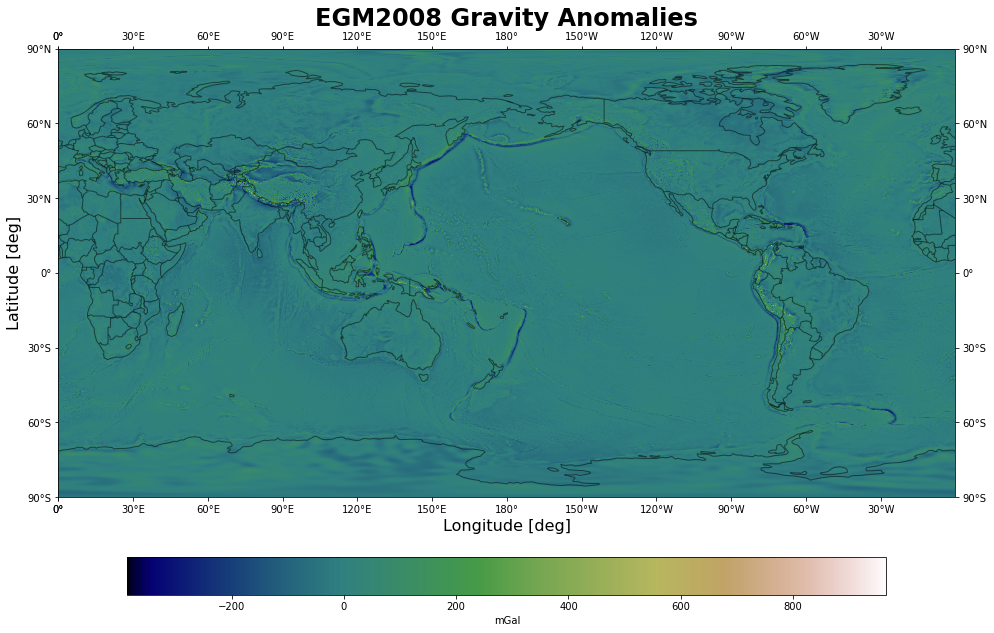

In [5]:
plot_egm2008(mGal, title='EGM2008 Gravity Anomalies',
             set_global=True, colorbar=True,
             colorbar_label='mGal')

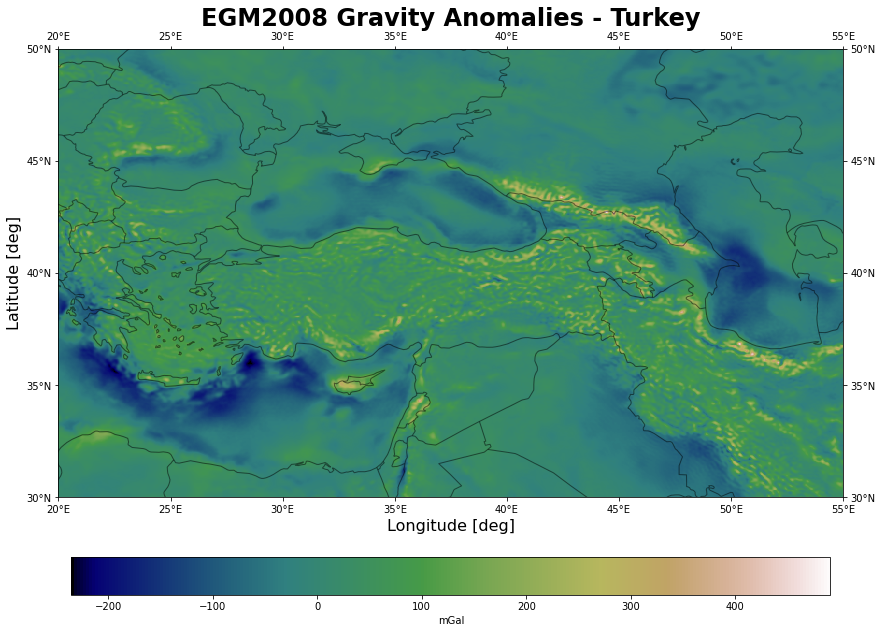

In [6]:
plot_egm2008(mGal, title='EGM2008 Gravity Anomalies - Turkey',
             lat_lo=30, lat_hi=50, lon_lo=20, lon_hi=55, tick=5,
             colorbar=True, colorbar_label='mGal')

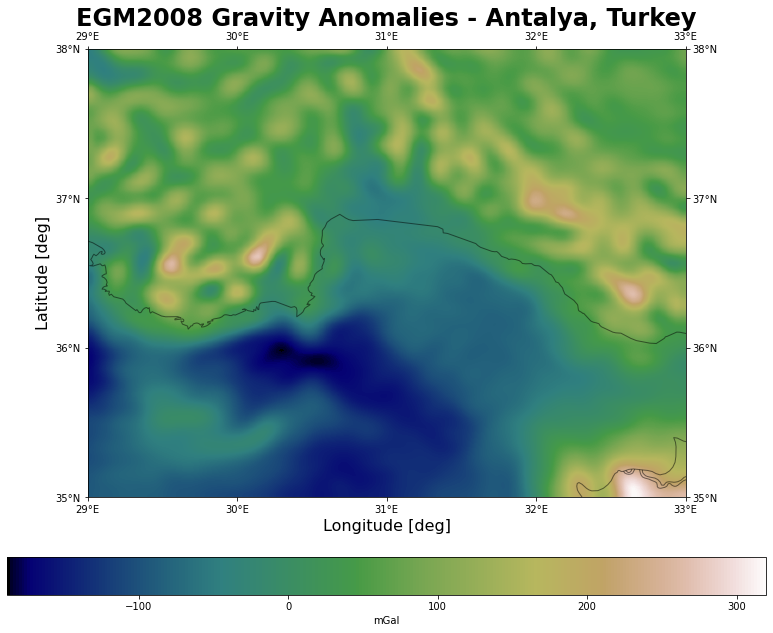

In [7]:
plot_egm2008(mGal, title='EGM2008 Gravity Anomalies - Antalya, Turkey',
             lat_lo=35, lat_hi=38, lon_lo=29, lon_hi=33, tick=1,
             interpolation='gaussian', colorbar=True, colorbar_label='mGal')

In [8]:
undulation = read_egm2008(kind='undulation', resolution=2.5,
                          path='/Users/oguzhan/Downloads/egm2008/undulation/')

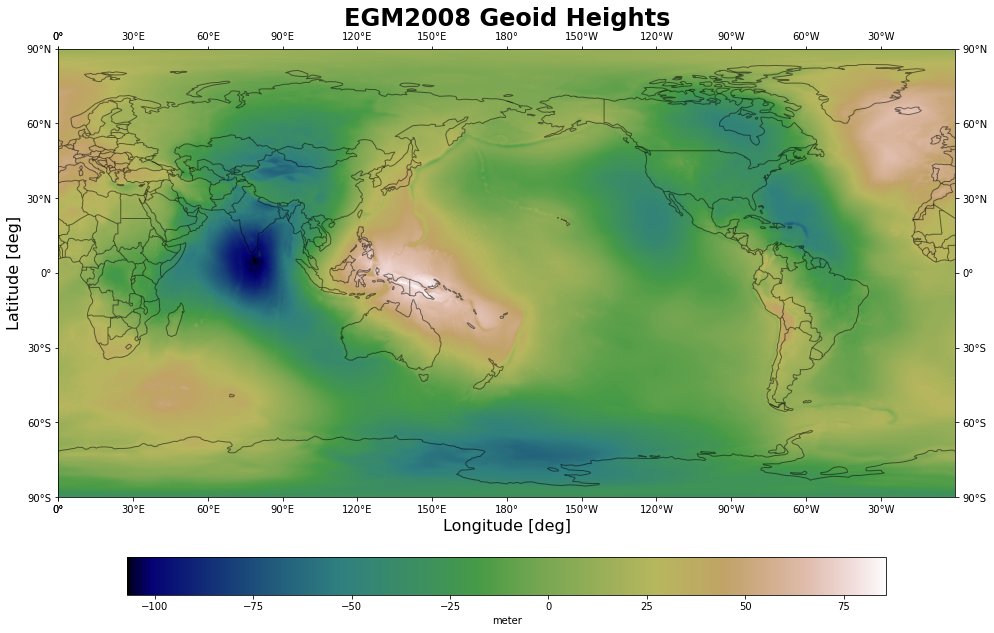

In [9]:
plot_egm2008(undulation, title='EGM2008 Geoid Heights',
             set_global=True, colorbar=True, colorbar_label='meter')

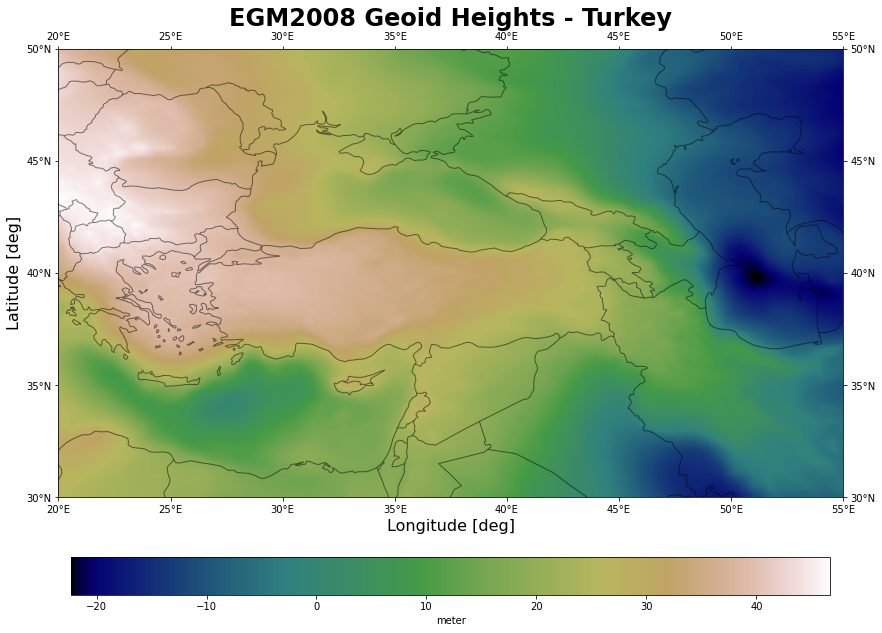

In [10]:
plot_egm2008(undulation, title='EGM2008 Geoid Heights - Turkey',
             lat_lo=30, lat_hi=50, lon_lo=20, lon_hi=55, tick=5,
             colorbar=True, colorbar_label='meter')

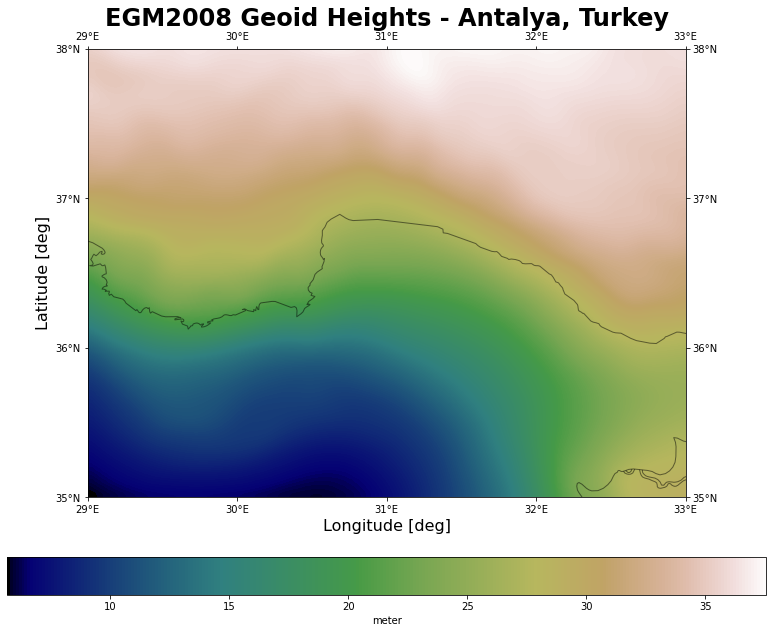

In [11]:
plot_egm2008(undulation, title='EGM2008 Geoid Heights - Antalya, Turkey',
             lat_lo=35, lat_hi=38, lon_lo=29, lon_hi=33, tick=1,
             interpolation='gaussian', colorbar=True, colorbar_label='meter')

In [12]:
# Akdeniz University, Faculty of Science
lat, lon = 36.89823, 30.65668

# Geoid Height [m]
interpolate_egm2008(undulation, latitude=lat, longitude=lon)

27.483